In [8]:
%load_ext autoreload
%autoreload 2

%matplotlib notebook

import logging
logging.basicConfig()

from pathlib import Path
from pprint import pprint

from tqdm import tqdm, trange

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

import fish

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
NOTEBOOK_NAME = "pipette"

HERE = Path.cwd().absolute()
DATA = HERE.parent / "data"
OUT = HERE / "out" / Path(NOTEBOOK_NAME).stem
print(HERE)
print(DATA)
print(OUT)

D:\projects\fish\dev
D:\projects\fish\data
D:\projects\fish\dev\out\pipette


In [11]:
frames = fish.cached_read(DATA / "D1-1.hsv")
frames.shape

Reading frames from D:\projects\fish\data\D1-1.hsv: 100%|██████████| 1816/1816 [01:18<00:00, 23.28it/s]
DEBUG:fish.io:Saved frames to D:\projects\fish\data\D1-1.hsv.cached


(1816, 1024, 1280)

In [12]:
diff = np.diff(frames, axis = 0)
abs_diff = np.abs(diff)
sum_abs_diff = np.sum(diff, axis = (1, 2))
sum_abs_diff.shape

(1815,)

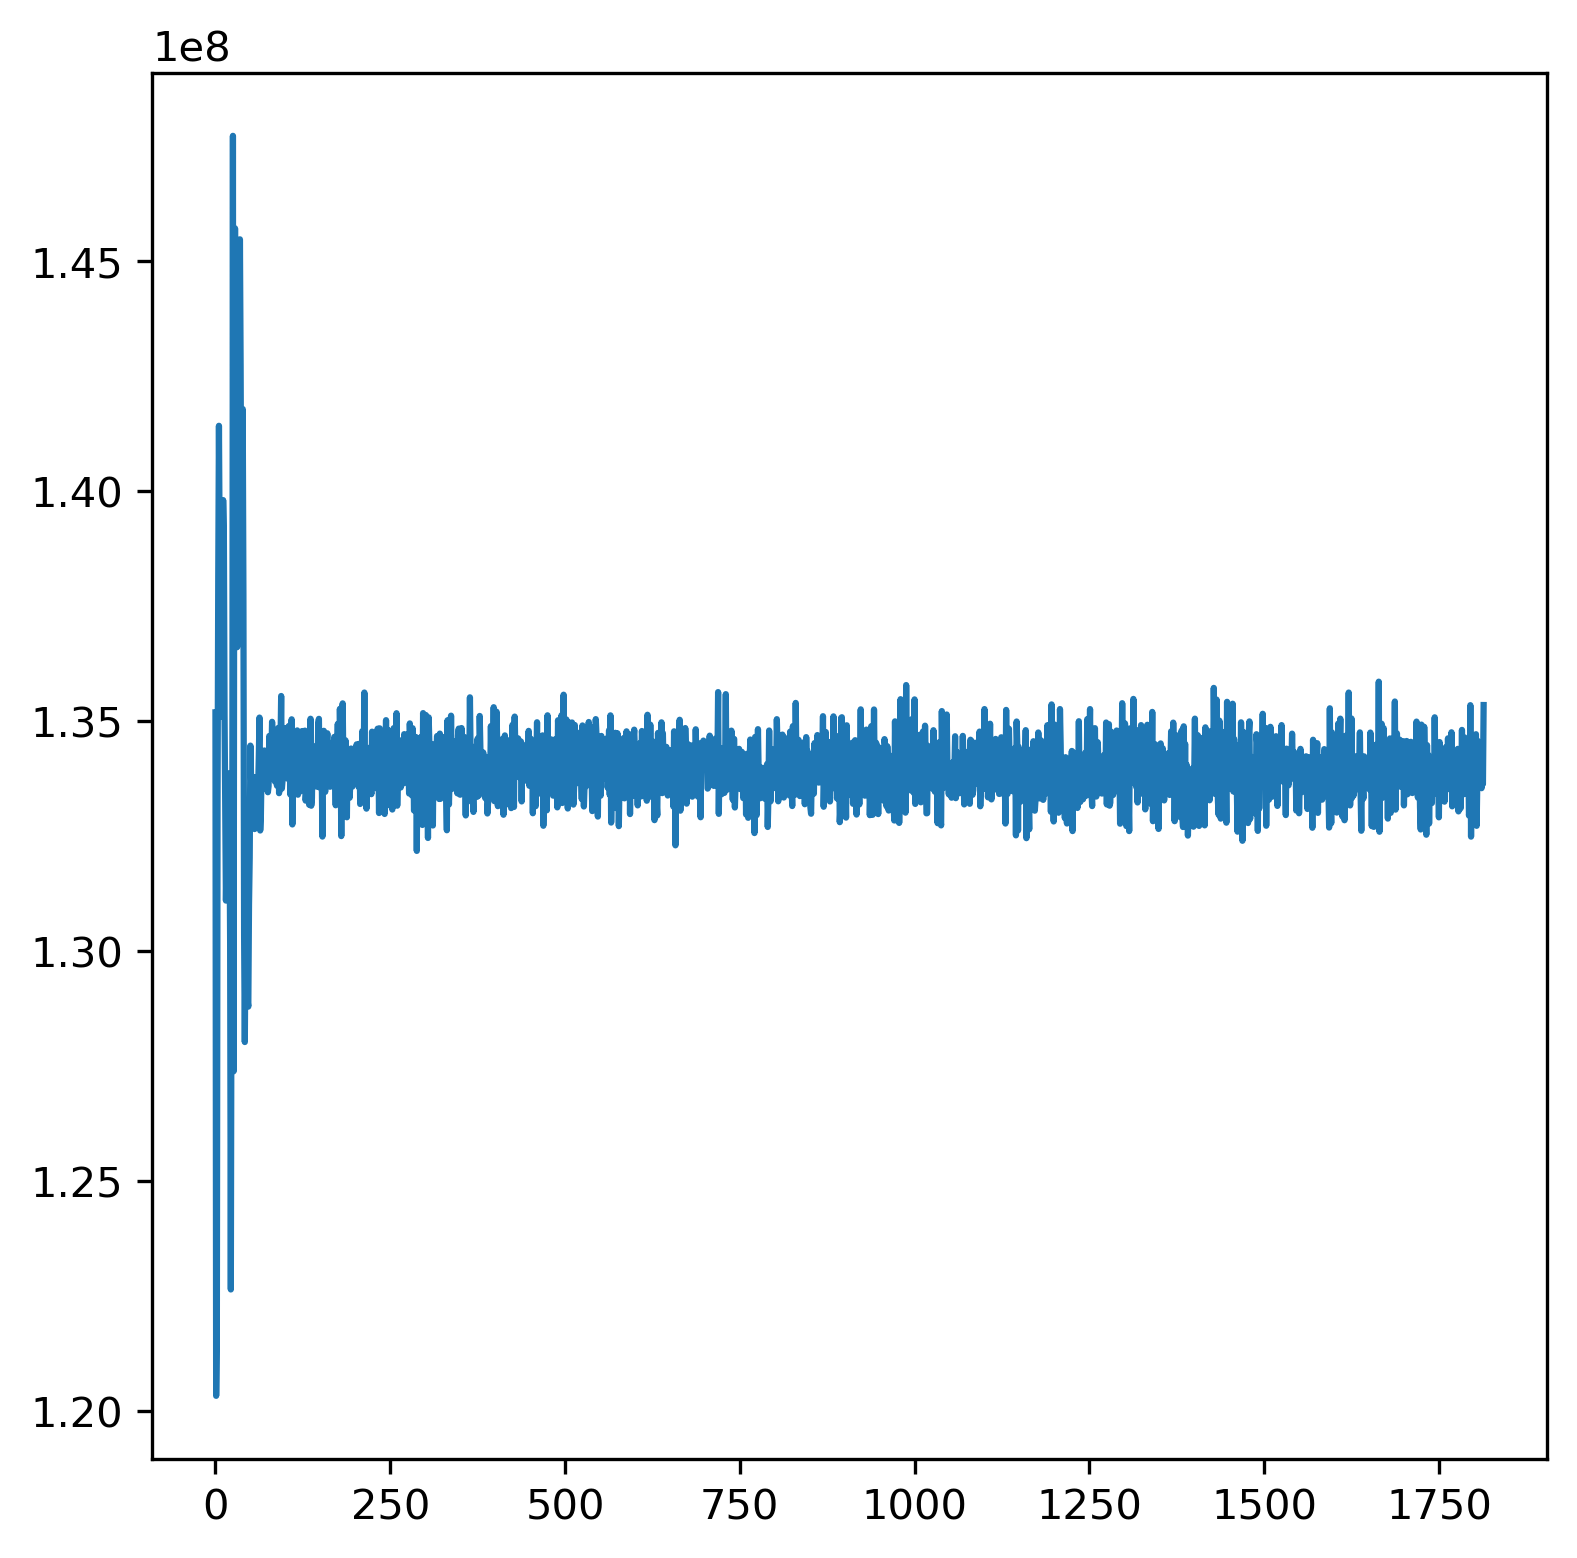

In [18]:
plt.close()
fig = plt.Figure(figsize = (6, 6), dpi = 300)
ax = fig.add_subplot(111)
ax.plot(sum_abs_diff)
fig

In [29]:
smoothed = fish.moving_average(sum_abs_diff, 10)
baseline = np.median(smoothed)
print(baseline)

133968036.75


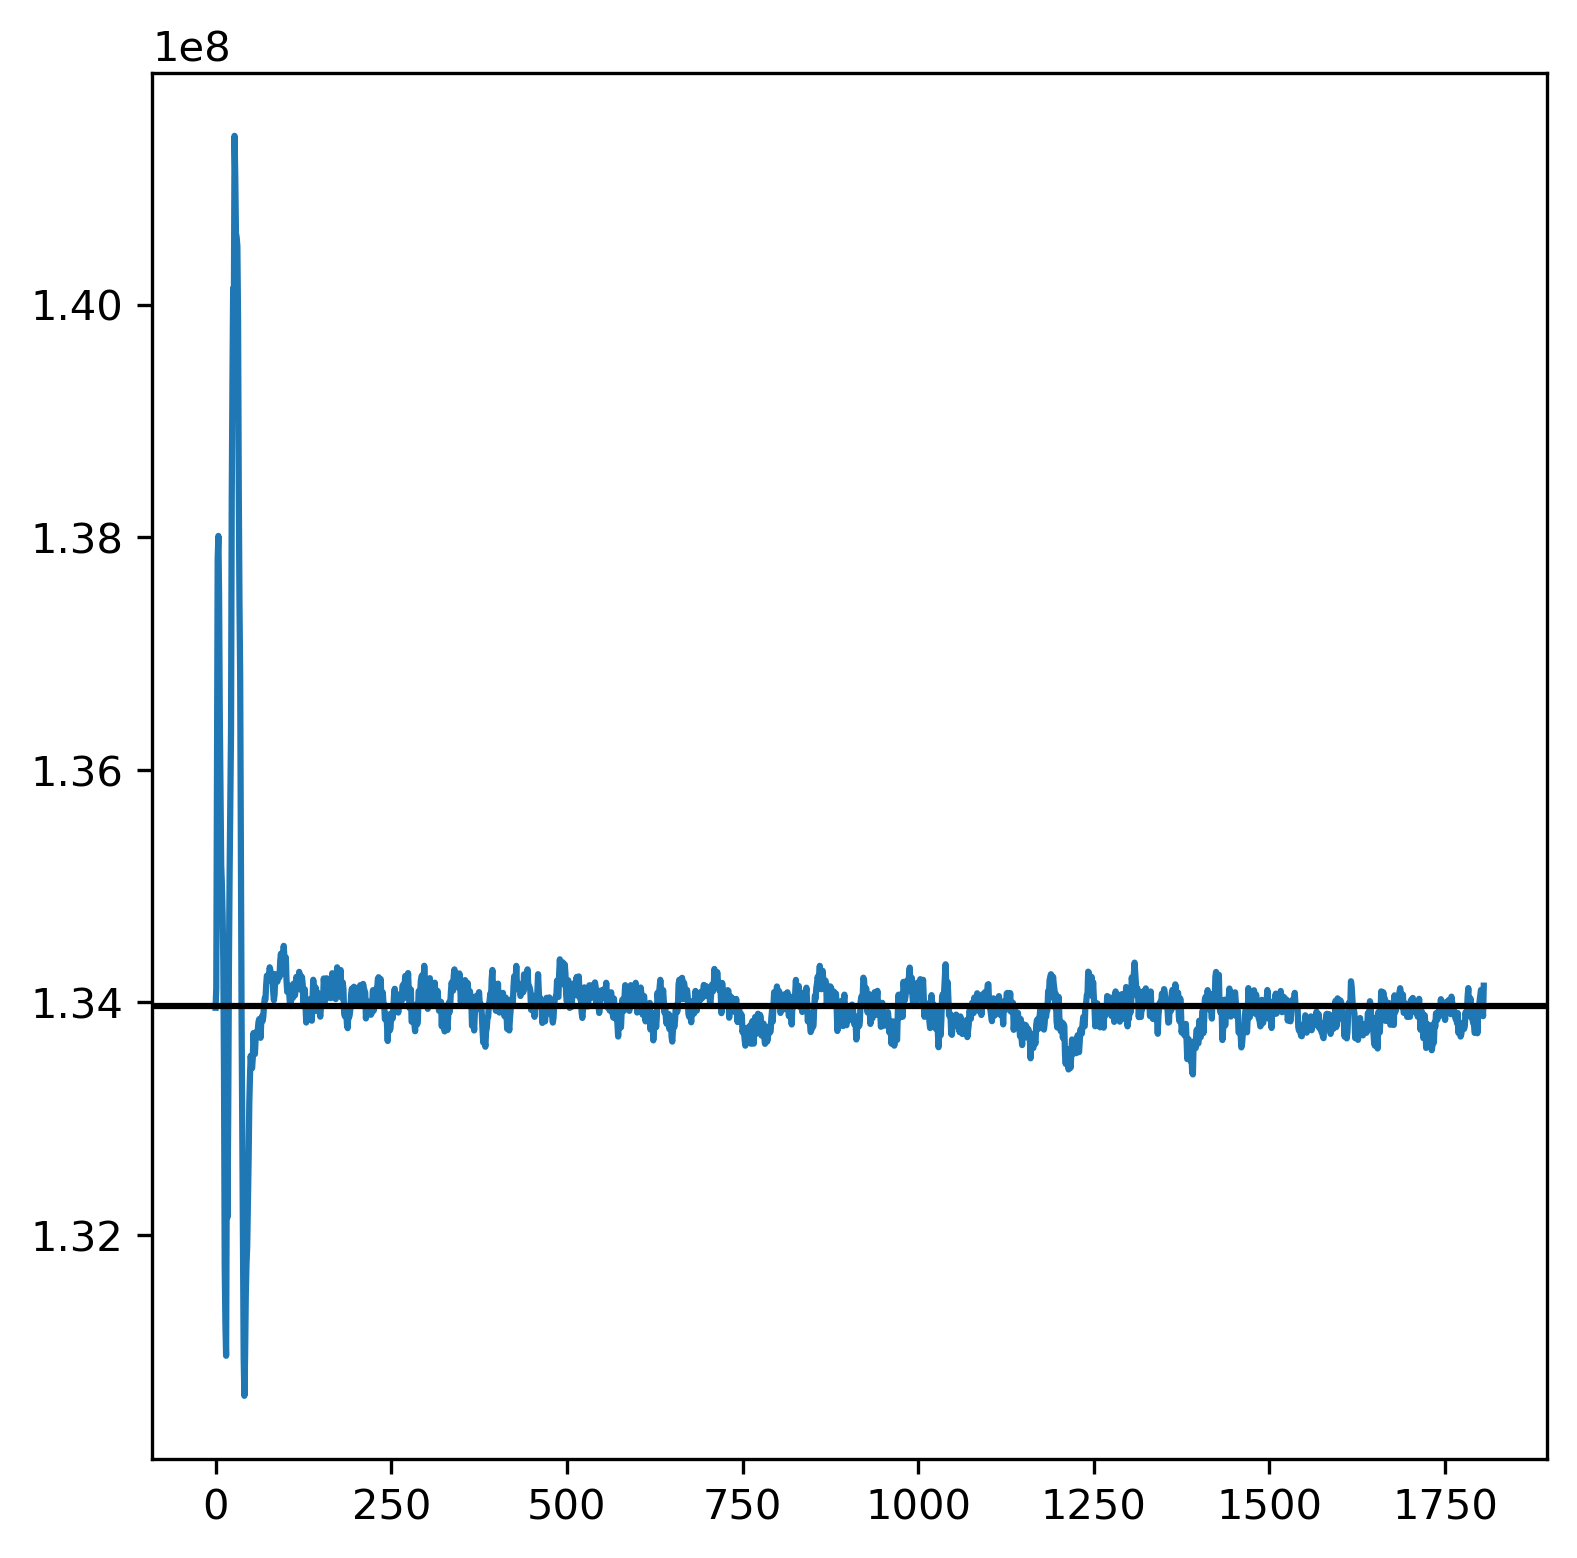

In [30]:
plt.close()
fig = plt.Figure(figsize = (6, 6), dpi = 300)
ax = fig.add_subplot(111)
ax.plot(smoothed)
ax.axhline(baseline, color = "black")
fig